In [3]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [33]:
import matplotlib.pyplot as plt


def show(tensor: torch.Tensor):
    tensor = tensor.detach().squeeze().cpu()
    plt.figure(figsize=(1, 1))
    plt.imshow(tensor, cmap="gray")
    plt.axis("off")
    plt.show()

In [4]:
device = torch.device("cpu")

if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator()

device

device(type='mps')

In [5]:
training_data = datasets.MNIST("data", train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST("data", train=False, download=True, transform=ToTensor())

In [6]:
training_data[0][0].shape

torch.Size([1, 28, 28])

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
from torch.utils.data import DataLoader

In [13]:
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
out, target = next(iter(train_loader))
out = out.to(device)
target = target.to(device)
predicted = net(out[0][0].flatten()).argmax()
actual = target[0]
print(f"Predicted: {predicted}, Actual: {actual}")

Predicted: 9, Actual: 2


In [54]:
from torch.utils.data import DataLoader
from IPython.display import display, clear_output


class Trainer:
    def __init__(self, model, loss_fn, optim_fn, training_data, test_data):
        self.model = model.to(device)
        self.loss_fn = loss_fn()
        self.optim = optim_fn(self.model.parameters(), lr=0.001)
        self.training_data = training_data
        self.test_data = test_data

    def train(self):
        train_loader = DataLoader(self.training_data, batch_size=64, shuffle=True)

        for data, targets in train_loader:
            self.optim.zero_grad()

            data = data.squeeze(1).flatten(1, 2)
            data = data.to(device)
            output = self.model(data)
            targets = targets.to(device)

            loss = self.loss_fn(output, targets)
            loss.backward()

            self.optim.step()

            correct = torch.sum(output.argmax(1) == targets).item()
            total = output.size(0)

            # clear_output(wait=True)
            # display(f"Training accuracy: {round((correct / total) * 100, 2)}")
            # display(f"Training loss: {loss.item()}")

    def validate(self):
        test_loader = DataLoader(self.test_data, batch_size=64, shuffle=True)

        correct = 0
        total = 0

        for data, targets in test_loader:
            data = data.squeeze(1).flatten(1, 2)
            data = data.to(device)

            output = self.model(data)
            targets = targets.to(device)

            correct += torch.sum(output.argmax(1) == targets).item()
            total += output.size(0)

        accuracy = round((correct / total) * 100, 2)
        return accuracy
        # print(f"Validation accuracy: {round((correct / total) * 100, 2)}\n")

In [58]:
from tqdm import tqdm

trainer = Trainer(net, nn.CrossEntropyLoss, optim.Adam, training_data, test_data)

epochs = 10
pbar = tqdm(range(epochs))
for i in pbar:
    trainer.train()
    accuracy = trainer.validate()
    pbar.set_description(f"Validation accuracy: {accuracy}\n")

Validation accuracy: 97.5500<?, ?it/s]
Validation accuracy: 97.550:02<?, ?it/s]
Validation accuracy: 97.410:02<00:25,  2.88s/it]
Validation accuracy: 97.410:05<00:25,  2.88s/it]
Validation accuracy: 97.390:05<00:22,  2.86s/it]
Validation accuracy: 97.390:08<00:22,  2.86s/it]
Validation accuracy: 97.380:08<00:20,  2.86s/it]
Validation accuracy: 97.380:11<00:20,  2.86s/it]
Validation accuracy: 97.440:11<00:17,  2.89s/it]
Validation accuracy: 97.440:14<00:17,  2.89s/it]
Validation accuracy: 97.450:14<00:14,  2.89s/it]
Validation accuracy: 97.450:17<00:14,  2.89s/it]
Validation accuracy: 97.580:17<00:11,  2.93s/it]
Validation accuracy: 97.580:20<00:11,  2.93s/it]
Validation accuracy: 97.360:20<00:08,  2.96s/it]
Validation accuracy: 97.360:23<00:08,  2.96s/it]
Validation accuracy: 97.300:23<00:05,  2.96s/it]
Validation accuracy: 97.300:26<00:05,  2.96s/it] 
Validation accuracy: 97.610:26<00:02,  2.92s/it]
Validation accuracy: 97.610:29<00:02,  2.92s/it]
Validation accuracy: 97.6100:29<00:00

In [59]:
torch.save(net.state_dict(), "model.pt")

In [60]:
model = Net()
model = model.to(device)
model.load_state_dict(torch.load("model.pt", weights_only=True, map_location=device))
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [61]:
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
inputs, targets = next(iter(train_loader))

input = inputs[0].squeeze(1).flatten(1, 2)
input = input.to(device)
input.requires_grad_()

target = targets[0]
target = target.to(device)

output = model(input).squeeze()

loss = F.cross_entropy(output, target)
loss.backward()

epsilon = 0.04
perturbed = input + epsilon * input.grad.sign()

perturbed = perturbed.unflatten(1, (28, 28))
input = input.unflatten(1, (28, 28))

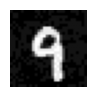

Prediction: 4
Actual: 9

Correct? False


In [64]:
perturbed_output = model(perturbed.squeeze().flatten()).argmax().item()
correct = target == perturbed_output

show(perturbed)
print(f"Prediction: {perturbed_output}\nActual: {target}\n\nCorrect? {correct}")